<a href="https://colab.research.google.com/github/Arta-DS/DS/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%D0%BD%D0%B0_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import zipfile
import os
from random import shuffle
import glob
import re

print(tf.__version__)
print(tf.executing_eagerly())

2.18.0
True


In [28]:
# Распаковка данных
def unpack_data():
    os.makedirs('extracted_train', exist_ok=True)
    os.makedirs('extracted_test', exist_ok=True)

    if os.path.exists('train.zip'):
        with zipfile.ZipFile('train.zip', 'r') as zip_ref:
            zip_ref.extractall('extracted_train')

    if os.path.exists('test.zip'):
        with zipfile.ZipFile('test.zip', 'r') as zip_ref:
            zip_ref.extractall('extracted_test')

unpack_data()

In [29]:
train_files = glob.glob('extracted_train/**/*.jpg', recursive=True)
test_files = glob.glob('extracted_test/**/*.jpg', recursive=True)

In [30]:
# Конфигурация
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

In [31]:
# Загрузка и предобработка изображения
def load_image(path):
    img = cv2.imread(path)[...,::-1]  # BGR -> RGB
    img = cv2.resize(img, IMG_SIZE)
    return mobilenet_v2.preprocess_input(img)

# Генератор для обучения
def fit_generator(files, batch_size=BATCH_SIZE):
    while True:
        shuffle(files)
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i+batch_size]
            x = np.array([load_image(path) for path in batch_files])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in batch_files])
            yield (x, y)

In [38]:
# Генератор для тестирования
def predict_generator(files):
    while True:
        for path in files:
            yield (load_image(path)[np.newaxis,...],)

In [32]:
# Разделение на train/val
val_samples = int(len(train_files) * 0.15)
shuffle(train_files)
val_files = train_files[:val_samples]
train_files = train_files[val_samples:]

# Создание генераторов
train_gen = fit_generator(train_files, BATCH_SIZE)
val_gen = fit_generator(val_files, BATCH_SIZE)

# Модель MobileNetV2
base_model = mobilenet_v2.MobileNetV2(weights='imagenet',
                                    include_top=False,
                                    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(base_model.input, x)
model.summary()

# Компиляция
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, save_freq=5):
        super().__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.filepath.format(epoch=epoch + 1))

In [34]:
# Callbacks
checkpoint = CustomModelCheckpoint('cats-dogs-model-{epoch:02d}.hdf5', save_freq=5)
early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

In [35]:
# Обучение
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_files) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_files) // BATCH_SIZE,
    epochs=50,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.8794 - loss: 0.2790 - val_accuracy: 0.9776 - val_loss: 0.0635
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.9678 - loss: 0.0862 - val_accuracy: 0.9782 - val_loss: 0.0565
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.9703 - loss: 0.0791 - val_accuracy: 0.9753 - val_loss: 0.0573
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.9733 - loss: 0.0741 - val_accuracy: 0.9786 - val_loss: 0.0531
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9745 - loss: 0.0693

332/332 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.9745 - loss: 0.0694 - val_accuracy: 0.9783 - val_loss: 0.0578
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9725 - loss: 0.0741 - val_accuracy: 0.9826 - val_loss: 0.0505
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.9729 - loss: 0.0740 - val_accuracy: 0.9775 - val_loss: 0.0573
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.9750 - loss: 0.0689 - val_accuracy: 0.9805 - val_loss: 0.0534
Epoch 9/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 0.9737 - loss: 0.0687 - val_accuracy: 0.9786 - val_loss: 0.0539
Epoch 10/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9723 - loss: 0.0730

332/332 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.9723 - loss: 0.0730 - val_accuracy: 0.9780 - val_loss: 0.0575
Epoch 11/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.9769 - loss: 0.0668 - val_accuracy: 0.9807 - val_loss: 0.0518


In [39]:
test_pred = model.predict(
    predict_generator(test_files),
    steps=len(test_files)
)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 308s 25ms/step


In [40]:
# Формирование submission
with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        filename = os.path.basename(path)
        img_id = re.search(r'(\d+)\.jpg$', filename).group(1)
        dst.write(f'{img_id},{score[0]}\n')

<ipython-input-42-fee8ee7ebff1>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score_scalar = float(score)  # или score.item(), или score[0]


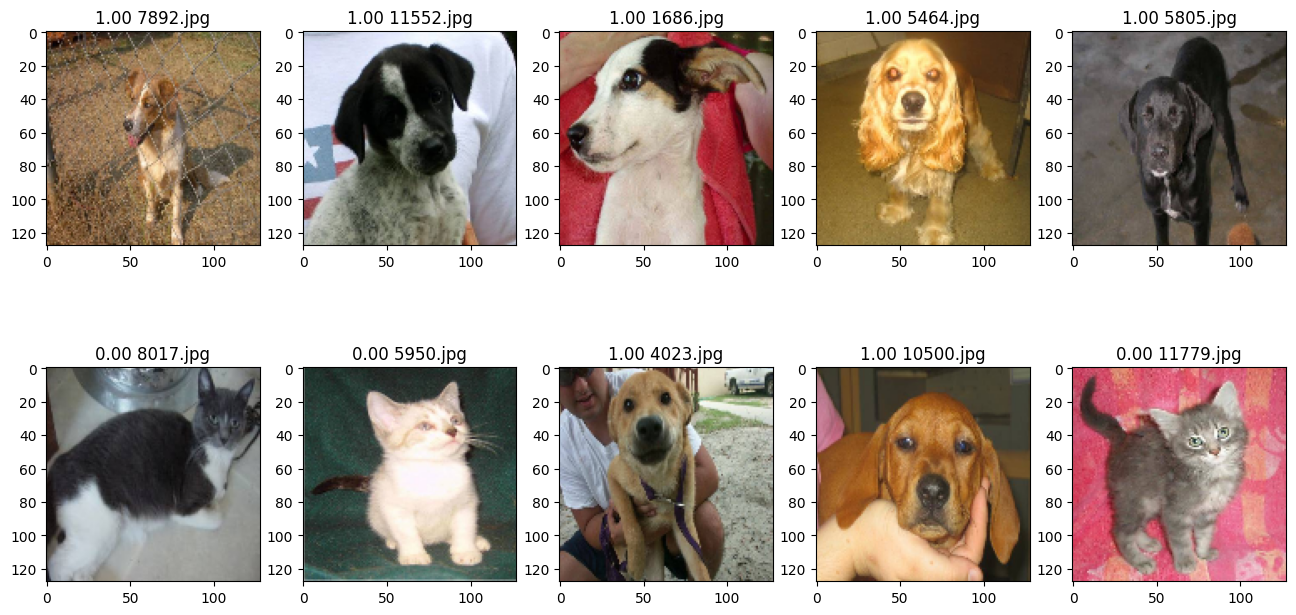

In [42]:
# Отображение примеров
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)

    # Преобразуем score в обычное число
    score_scalar = float(score)  # или score.item(), или score[0]

    subplot.set_title(f'{score_scalar:.2f} {os.path.basename(path)}')
    img = cv2.imread(path)[..., ::-1]  # BGR -> RGB
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)